# Segmentation baselines

## Init

In [1]:
# import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
from scipy import signal
import os

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
from scipy.stats import nbinom
import ssm
from ssm.util import rle, find_permutation

In [3]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
)

In [4]:
# %matplotlib ipympl

## Data files

In [5]:
data_path_root = Path("../table-task-ur5e")
data_path_root.exists()

True

In [6]:
bagfiles = list(data_path_root.glob("*.bag"))
bagfiles

[PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-08-23_2025-08-05-21-08-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-33-31_2025-08-05-21-33-31.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-36-29_2025-08-05-21-36-29.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-43-41_2025-08-05-21-43-41.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-04_18-10-23_2025-09-04-18-10-23_test-image.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [7]:
filenum = -1
bagfile = bagfiles[filenum]
bagfile

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')

In [8]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

## Preprocessing

In [9]:
traj = extract_eef_data_from_rosbag(bagfile)
traj

Extracting TF & gripper data from Bag file...


  0%|          | 0/183488 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


,x,y,z,timestamp,gripper
0,-0.057518,-0.349359,0.245916,2025-09-08 18:46:19.430824291-05:00,0.01
1,-0.057527,-0.349371,0.245943,2025-09-08 18:46:19.432620296-05:00,0.01
2,-0.057521,-0.349371,0.245940,2025-09-08 18:46:19.434438816-05:00,0.01
3,-0.057525,-0.349373,0.245945,2025-09-08 18:46:19.436862995-05:00,0.01
4,-0.057515,-0.349382,0.245951,2025-09-08 18:46:19.438580443-05:00,0.01
...,...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,2025-09-08 18:48:14.634462638-05:00,0.01
57562,-0.079040,-0.339984,0.226385,2025-09-08 18:48:14.636379567-05:00,0.01
57563,-0.079073,-0.339983,0.226388,2025-09-08 18:48:14.638744970-05:00,0.01
57564,-0.079063,-0.339978,0.226381,2025-09-08 18:48:14.640788775-05:00,0.01


In [10]:
df = traj.diff().mean().timestamp.total_seconds()
df

0.002001

In [11]:
downsampling = 10

In [12]:
freq = 1 / (df * downsampling)
freq

49.97501249375313

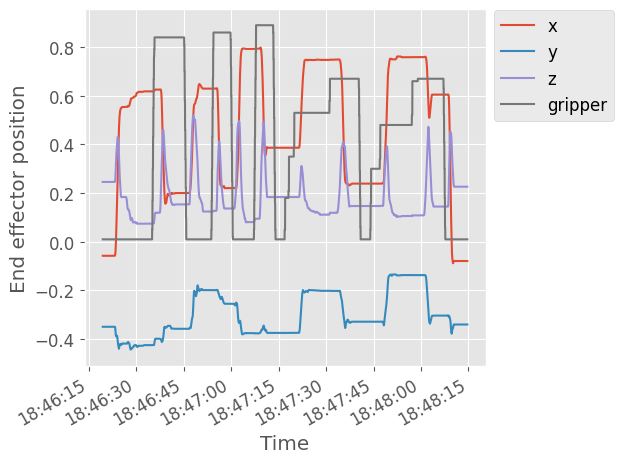

In [13]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [14]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
gt_segm_dict

{'filename': 'rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag',
 'HigherLevel': {'plate': {'ini': 1757375183, 'end': 1757375205},
  'cup': {'ini': 1757375207, 'end': 1757375220},
  'napkin': {'ini': 1757375220, 'end': 1757375232},
  'spoon': {'ini': 1757375235, 'end': 1757375258},
  'fork': {'ini': 1757375262, 'end': 1757375288}},
 'LowerLevel': {'reaching': [{'ini': 1757375183, 'end': 1757375194},
   {'ini': 1757375207, 'end': 1757375212},
   {'ini': 1757375220, 'end': 1757375226},
   {'ini': 1757375235, 'end': 1757375253},
   {'ini': 1757375262, 'end': 1757375280}],
  'placing': [{'ini': 1757375197, 'end': 1757375205},
   {'ini': 1757375215, 'end': 1757375220},
   {'ini': 1757375228, 'end': 1757375232},
   {'ini': 1757375253, 'end': 1757375258},
   {'ini': 1757375280, 'end': 1757375288}]}}

### Higher level movements

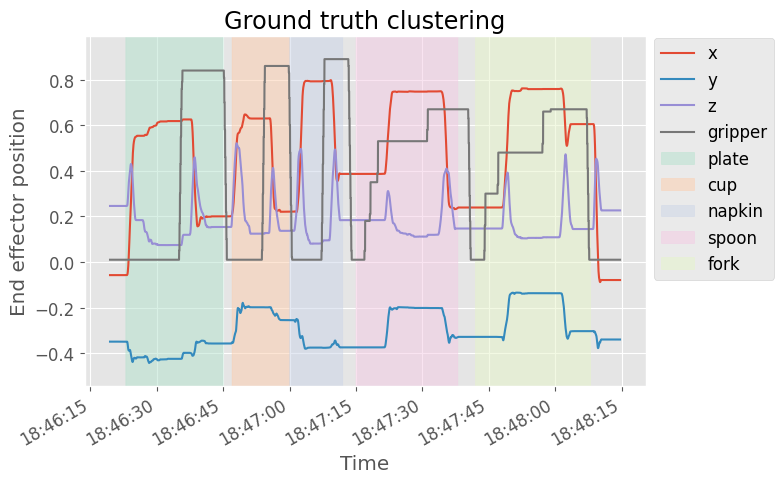

In [15]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=fill_min - 1,
            y2=fill_max + 1,
            color=cmap[sect_i],
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

### Lower level movements

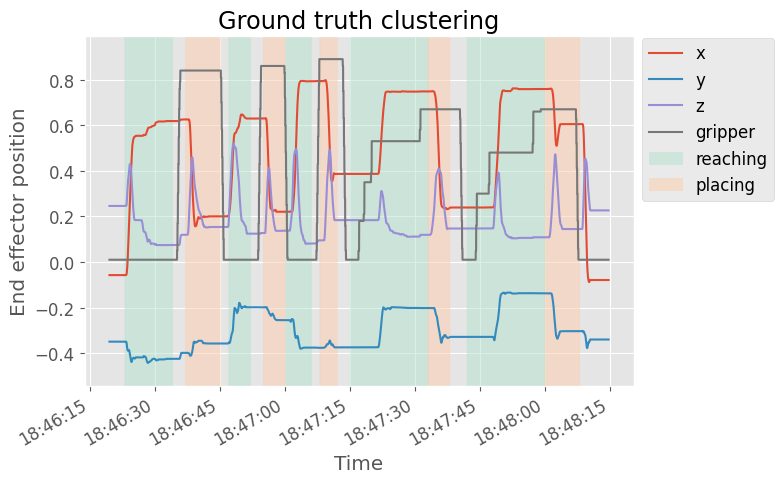

In [16]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = traj.timestamp[
                (
                    traj.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    traj.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=fill_min - 1,
                    y2=fill_max + 1,
                    color=cmap[sect_i],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=fill_min - 1,
                    y2=fill_max + 1,
                    color=cmap[sect_i],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    # label=sect_key,
                )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Segmentation

### Preprocessing

In [17]:
true_cps = np.ones((len(gt_segm_dict["HigherLevel"]) - 1)) * np.nan
for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
    sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
    if sect_i < len(true_cps):
        true_cps[sect_i] = sect_dict_current["end"]
true_cps

array([1.75737520e+09, 1.75737522e+09, 1.75737523e+09, 1.75737526e+09])

In [18]:
labels = gt_segm_dict["HigherLevel"].keys()
labels

dict_keys(['plate', 'cup', 'napkin', 'spoon', 'fork'])

In [19]:
X = traj.drop(columns=["timestamp"])
X

,x,y,z,gripper
0,-0.057518,-0.349359,0.245916,0.01
1,-0.057527,-0.349371,0.245943,0.01
2,-0.057521,-0.349371,0.245940,0.01
3,-0.057525,-0.349373,0.245945,0.01
4,-0.057515,-0.349382,0.245951,0.01
...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,0.01
57562,-0.079040,-0.339984,0.226385,0.01
57563,-0.079073,-0.339983,0.226388,0.01
57564,-0.079063,-0.339978,0.226381,0.01


In [20]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
X_scaled

array([[0.03466634, 0.30298799, 0.38457212, 0.        ],
       [0.03465621, 0.30295002, 0.38463162, 0.        ],
       [0.03466358, 0.30294936, 0.38462524, 0.        ],
       ...,
       [0.01035104, 0.3333613 , 0.3408574 , 0.        ],
       [0.01036216, 0.33337666, 0.34084089, 0.        ],
       [0.01035894, 0.33336528, 0.34081912, 0.        ]], shape=(57566, 4))

In [21]:
downsampling_factor = 10
X_down = signal.decimate(x=X, q=downsampling_factor, axis=0)
X_down

array([[-0.05685907, -0.34535993,  0.24310149,  0.00988553],
       [-0.05686354, -0.34537592,  0.24312374,  0.00988553],
       [-0.05686813, -0.34537414,  0.24311757,  0.00988553],
       ...,
       [-0.07815416, -0.33608224,  0.22377514,  0.00988553],
       [-0.07815445, -0.33608737,  0.22377973,  0.00988553],
       [-0.07815985, -0.33609272,  0.22378373,  0.00988553]],
      shape=(5757, 4))

In [22]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
X_down_scaled = minmaxscaler.fit_transform(X_down)
X_down_scaled

array([[0.03468915, 0.30297847, 0.38453166, 0.01339656],
       [0.03468405, 0.30292607, 0.38458204, 0.01339656],
       [0.03467881, 0.3029319 , 0.38456808, 0.01339656],
       ...,
       [0.01038961, 0.33338659, 0.34076122, 0.01339656],
       [0.01038928, 0.33336977, 0.34077161, 0.01339656],
       [0.01038312, 0.33335225, 0.34078069, 0.01339656]], shape=(5757, 4))

In [23]:
tscv = TimeSeriesSplit(
    n_splits=3,
)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)

### HSMM

In [24]:
# npr.seed(0)

# # Set the parameters of the HMM
# T = 5000  # number of time bins
# K = 5  # number of discrete states
# D = 2  # number of observed dimensions
K = len(labels)
D = X_down_scaled.shape[1]
# y = X_down_scaled
y = X_scaled

In [25]:
# # Make an HMM with the true parameters
# T = 5000  # number of time bins
# true_hsmm = ssm.HSMM(K, D, observations="gaussian")
# true_hsmm.transitions.rs
# z, y = true_hsmm.sample(T)
# z_test, y_test = true_hsmm.sample(T)
# true_ll = true_hsmm.log_probability(y)

In [26]:
# Fit an HSMM
N_em_iters = 60

print("Fitting Gaussian HSMM with EM")
hsmm = ssm.HSMM(K, D, observations="gaussian")
hsmm_em_lls = hsmm.fit(y, method="em", num_iters=N_em_iters)

print("Fitting Gaussian HMM with EM")
# hmm = ssm.HMM(K, D, observations="gaussian", transitions="recurrent")
hmm = ssm.HMM(K, D, observations="gaussian")
hmm_em_lls = hmm.fit(y, method="em", num_iters=N_em_iters)

Fitting Gaussian HSMM with EM


/home/kir0ul/Projects/ssm/.direnv/python-3.13.7/lib64/python3.13/site-packages/autograd/tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


  0%|          | 0/60 [00:00<?, ?it/s]

Fitting Gaussian HMM with EM


  0%|          | 0/60 [00:00<?, ?it/s]

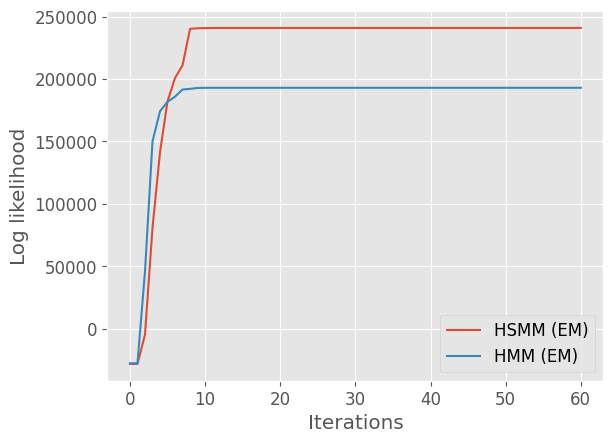

In [42]:
with plt.style.context("ggplot_perso.mplstyle"):
    # Plot log likelihoods (fit model is typically better)
    fig, ax = plt.subplots()
    ax.plot(hsmm_em_lls, ls="-", label="HSMM (EM)")
    ax.plot(hmm_em_lls, ls="-", label="HMM (EM)")
    # plt.plot(true_ll * np.ones(N_em_iters), ":", label="true")
    ax.legend(loc="lower right")
    ax.set_ylabel("Log likelihood")
    ax.set_xlabel("Iterations")
    # fig.tight_layout()
    plt.show()

In [28]:
# # Print the test likelihoods (true model is typically better)
# print("Test log likelihood")
# # print("True HSMM: ", true_hsmm.log_likelihood(y_test))
# print("Fit HSMM:  ", hsmm.log_likelihood(y_test))
# print("Fit HMM: ", hmm.log_likelihood(y_test))

In [29]:
# Plot the true and inferred states
# hsmm.permute(find_permutation(z, hsmm.most_likely_states(y)))
hsmm_z = hsmm.most_likely_states(y)
# hmm.permute(find_permutation(z, hmm.most_likely_states(y)))
hmm_z = hsmm.most_likely_states(y)

/home/kir0ul/Projects/ssm/.direnv/python-3.13.7/lib64/python3.13/site-packages/autograd/tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


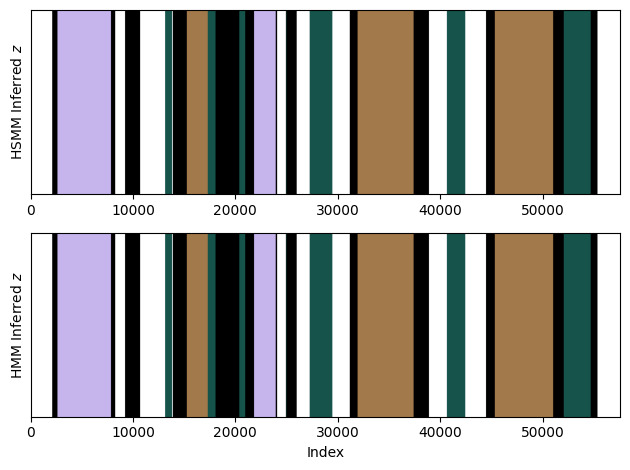

In [48]:
# Plot the true and inferred discrete states
# plt.figure(figsize=(8, 6))
# plt.subplot(311)
# plt.imshow(z[None, :1000], aspect="auto", cmap="cubehelix", vmin=0, vmax=K - 1)
# plt.xlim(0, 1000)
# plt.ylabel("True $z")
# plt.yticks([])

# plt.subplot(312)
plt.subplot(211)
# plt.imshow(hsmm_z[None, :1000], aspect="auto", cmap="cubehelix", vmin=0, vmax=K - 1)
plt.imshow(hsmm_z[None, :], aspect="auto", cmap="cubehelix", vmin=0, vmax=K - 1)
# plt.xlim(0, 1000)
plt.ylabel("HSMM Inferred $z$")
plt.yticks([])

# plt.subplot(313)
plt.subplot(212)
# plt.imshow(hmm_z[None, :1000], aspect="auto", cmap="cubehelix", vmin=0, vmax=K - 1)
plt.imshow(hmm_z[None, :], aspect="auto", cmap="cubehelix", vmin=0, vmax=K - 1)
# plt.xlim(0, 1000)
plt.ylabel("HMM Inferred $z$")
plt.yticks([])
# plt.xlabel("time")
plt.xlabel("Index")

plt.tight_layout()
plt.show()

In [31]:
# Plot the true and inferred duration distributions
# states, durations = rle(z)
inf_states, inf_durations = rle(hsmm_z)
hmm_inf_states, hmm_inf_durations = rle(hsmm_z)
# max_duration = max(np.max(durations), np.max(inf_durations), np.max(hmm_inf_durations))
# dd = np.arange(max_duration, step=1)

In [32]:
# plt.figure(figsize=(3 * K, 9))
# for k in range(K):
#     # Plot the durations of the true states
#     plt.subplot(3, K, k + 1)
#     plt.hist(durations[states == k] - 1, dd, density=True)
#     plt.plot(
#         dd,
#         nbinom.pmf(dd, true_hsmm.transitions.rs[k], 1 - true_hsmm.transitions.ps[k]),
#         "-k",
#         lw=2,
#         label="true",
#     )
#     if k == K - 1:
#         plt.legend(loc="lower right")
#     plt.title("State {} (N={})".format(k + 1, np.sum(states == k)))

#     # Plot the durations of the inferred states
#     plt.subplot(3, K, K + k + 1)
#     plt.hist(inf_durations[inf_states == k] - 1, dd, density=True)
#     plt.plot(
#         dd,
#         nbinom.pmf(dd, hsmm.transitions.rs[k], 1 - hsmm.transitions.ps[k]),
#         "-r",
#         lw=2,
#         label="hsmm inf.",
#     )
#     if k == K - 1:
#         plt.legend(loc="lower right")
#     plt.title("State {} (N={})".format(k + 1, np.sum(inf_states == k)))

#     # Plot the durations of the inferred states
#     plt.subplot(3, K, 2 * K + k + 1)
#     plt.hist(hmm_inf_durations[hmm_inf_states == k] - 1, dd, density=True)
#     plt.plot(
#         dd,
#         nbinom.pmf(dd, 1, 1 - hmm.transitions.transition_matrix[k, k]),
#         "-r",
#         lw=2,
#         label="hmm inf.",
#     )
#     if k == K - 1:
#         plt.legend(loc="lower right")
#     plt.title("State {} (N={})".format(k + 1, np.sum(inf_states == k)))
# plt.tight_layout()

# plt.show()

In [52]:
classes_id = np.unique([hsmm_z, hmm_z])
classes_id

array([0, 1, 2, 3, 4])

In [57]:
def find_subsegments(classes, class_id):
    select_idx = np.argwhere(np.array(classes) == class_id).squeeze()
    cut_pts = np.argwhere(np.diff(select_idx) > 1).squeeze(axis=1)
    # rm_idx = np.argwhere(np.logical_or(cut_pts == select_idx[0], cut_pts == select_idx[-1]))
    # cut_pts = np.delete(cut_pts, rm_idx, None)
    subsegms = []
    if cut_pts.any():
        subsegms.append(select_idx[0 : cut_pts[0]])
        if cut_pts.size > 1:
            for idx, cpt in enumerate(cut_pts[:-1]):
                subsegms.append(select_idx[cpt + 1 : cut_pts[idx + 1]])
        subsegms.append(select_idx[cut_pts[-1] + 1 : -1])
    else:
        subsegms.append(select_idx)
    subsegms = [item for item in subsegms if item.size > 0]
    return subsegms

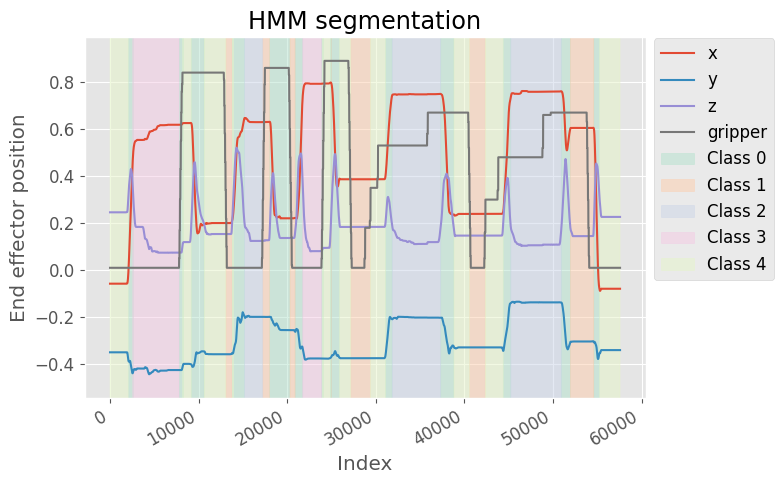

In [66]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(traj.index, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.index, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.index, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.index, traj.gripper, label="gripper")  # , color=cmap[3])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])

    for idx, class_id in enumerate(classes_id):
        # select_idx = np.argwhere(np.array(classes) == class_id).squeeze()
        # x = select_idx[np.concat([[False], np.diff(select_idx) == 1])]
        subsegms = find_subsegments(classes=hmm_z, class_id=class_id)
        for jdx, subsegm in enumerate(subsegms):
            if jdx == 0:
                ax.fill_between(
                    x=subsegm,
                    y1=fill_min.min() - 1,
                    y2=fill_max.max() + 1,
                    color=cmap[idx],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    x=subsegm,
                    y1=fill_min.min() - 1,
                    y2=fill_max.max() + 1,
                    color=cmap[idx],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    # label=f"Class {class_id}",
                )

    ax.set_ylim(bottom=fill_min.min() - 0.1, top=fill_max.max() + 0.1)
    ax.set_xlabel("Index")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("HMM segmentation")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

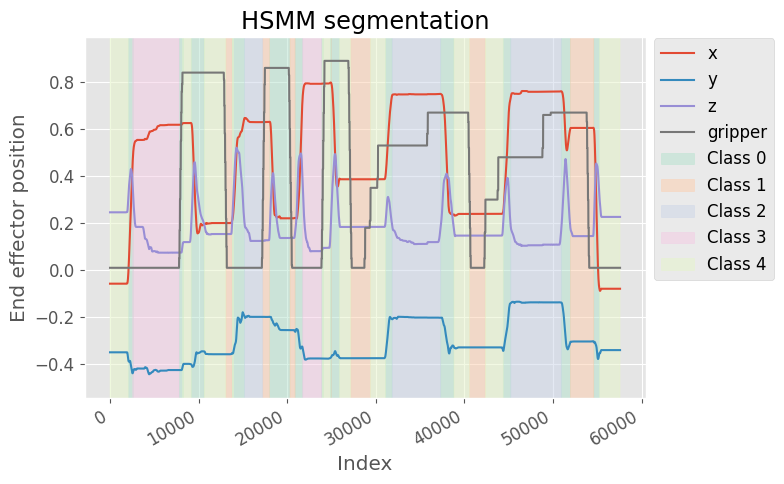

In [67]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(traj.index, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.index, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.index, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.index, traj.gripper, label="gripper")  # , color=cmap[3])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])

    for idx, class_id in enumerate(classes_id):
        # select_idx = np.argwhere(np.array(classes) == class_id).squeeze()
        # x = select_idx[np.concat([[False], np.diff(select_idx) == 1])]
        subsegms = find_subsegments(classes=hsmm_z, class_id=class_id)
        for jdx, subsegm in enumerate(subsegms):
            if jdx == 0:
                ax.fill_between(
                    x=subsegm,
                    y1=fill_min.min() - 1,
                    y2=fill_max.max() + 1,
                    color=cmap[idx],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    x=subsegm,
                    y1=fill_min.min() - 1,
                    y2=fill_max.max() + 1,
                    color=cmap[idx],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    # label=f"Class {class_id}",
                )

    ax.set_ylim(bottom=fill_min.min() - 0.1, top=fill_max.max() + 0.1)
    ax.set_xlabel("Index")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("HSMM segmentation")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()